Image Deconvolution (ADMM w/ Total Variation and Circulant Blur)
================================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve
an image deconvolution problem with isotropic total variation (TV)
regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - A \mathbf{x} \|_2^2
  + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is Toeplitz matrix, $\mathbf{y}$ is the blurred image, $C$
is a 2D Finite Difference operator, and $\mathbf{x}$ is the desired
image.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.CircularConvolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Set up an ADMM solver object.

In [4]:
λ = 2e-2  # L1 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L21Norm()  # regularization functionals gi
C = linop.FiniteDifference(x_gt.shape, circular=True)
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=CircularConvolveSolver(),
    verbose=True,
)

Run the solver.

In [5]:
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.27e+00  2.706e+02    8.268e+00  6.982e+00
   1  2.45e+00  2.895e+02    2.569e+00  4.968e+00
   2  2.46e+00  2.839e+02    1.731e+00  3.640e+00
   3  2.46e+00  2.822e+02    1.264e+00  3.210e+00
   4  2.47e+00  2.810e+02    9.673e-01  2.867e+00
   5  2.47e+00  2.800e+02    7.889e-01  2.573e+00
   6  2.48e+00  2.792e+02    6.692e-01  2.317e+00
   7  2.48e+00  2.786e+02    5.793e-01  2.109e+00
   8  2.49e+00  2.781e+02    5.049e-01  1.936e+00
   9  2.49e+00  2.777e+02    4.468e-01  1.788e+00
  10  2.49e+00  2.773e+02    4.006e-01  1.662e+00
  11  2.50e+00  2.770e+02    3.577e-01  1.556e+00
  12  2.50e+00  2.767e+02    3.206e-01  1.463e+00
  13  2.51e+00  2.765e+02    2.912e-01  1.379e+00
  14  2.51e+00  2.763e+02    2.669e-01  1.305e+00
  15  2.51e+00  2.761e+02    2.444e-01  1.239e+00
  16  2.52e+00  2.759e+02    2.259e-01  1.177e+00
  17  2.52e+00  2.757e+02    2.093e-01  1.122e+00


  47  2.65e+00  2.740e+02    5.128e-02  4.221e-01
  48  2.65e+00  2.740e+02    5.007e-02  4.111e-01
  49  2.66e+00  2.740e+02    4.884e-02  4.005e-01


Show the recovered image.

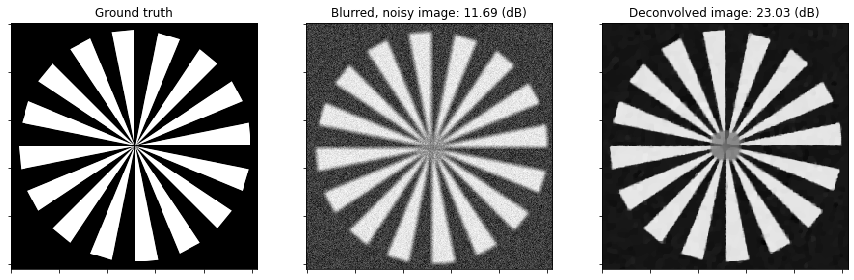

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, y), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

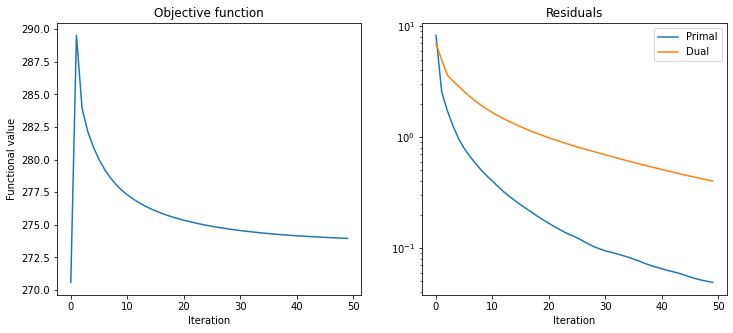

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()